In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from io import StringIO
import numpy as np
import os

# Verify
print("Current Working Directory:", os.getcwd())

metadata = "./results/ERM_hypertag_stoic-energy-14_test_tsne_metadata.csv"
md_df = pd.read_csv(metadata)
md_df
# Comorbidity columns with [1, 0, -1, nan] values
comorbidity_columns = ['Enlarged Cardiomediastinum', 'Cardiomegaly', 'Lung Opacity',
                       'Lung Lesion', 'Edema', 'Consolidation', 'Pneumonia',
                       'Atelectasis', 'Pneumothorax', 'Pleural Effusion',
                       'Pleural Other', 'Fracture', 'Support Devices', 'No Finding']

# Categorical variables
categorical_columns = ['sex', 'race', 'ethnicity', 'interpreter_needed',
                       'insurance_type', 'deceased']

# Continuous variables
continuous_columns = ['age', 'recent_bmi']

def map_comorbidity_values(value):
    if pd.isna(value):
        return 'missing'
    elif value == 1:
        return 'positive'
    elif value == 0:
        return 'uncertain'
    elif value == -1:
        return 'negative'
    else:
        return 'other'  # For any unexpected values

# Apply mapping to comorbidity columns
for col in comorbidity_columns:
    md_df[col] = md_df[col].apply(map_comorbidity_values)
    
# Define bins for 'age'
age_bins = [0, 40, 60, np.inf]
age_labels = ['0-40', '40-60', '60+']
md_df['age_bin'] = pd.cut(md_df['age'], bins=age_bins, labels=age_labels, right=False)

# Define bins for 'recent_bmi'
bmi_bins = [0, 18.5, 25, 30, 40, np.inf]
bmi_labels = ['Underweight', 'Normal', 'Overweight', 'Obese', 'Morbidly Obese']
md_df['bmi_bin'] = pd.cut(md_df['recent_bmi'], bins=bmi_bins, labels=bmi_labels, right=False)

binned_columns = ['age_bin', 'bmi_bin']

attributes_to_process = comorbidity_columns + categorical_columns + binned_columns


Current Working Directory: ../../subgroups_eval


In [2]:
from sklearn.metrics import roc_auc_score
import re

# --- Sample Data: Replace with your file paths if reading from disk ---
data = "./results/results_persample_l3_valtest_clip_imagenet_w10.csv"
df = pd.read_csv(data)
df = df[df["split"] == "test"]

df = df.pivot_table(
    index=['name', 'split', 'true_subgroup_idx', 'y_true', 'y_pred'],
    columns=['seed', 'weight', 'n_slices'],
    values='discovered_subgroup_idx'
).reset_index()

def flatten_column(col):
    # If the column is a tuple with exactly 3 elements,
    # assume it's from the pivoted values (seed, weight, n_slices)
    #print(len(col), col)
    if isinstance(col, tuple) and len(col) == 3 and col[1] != "":
        seed, weight, n_slices = col
        return f"discovered_subgroup_idx_r{seed}_w{weight}_s{n_slices}"
    # If it's a tuple with a single element, assume it's an index column
    elif isinstance(col, tuple) and len(col) == 1:
        return col[0]
    return col[0]

def extract_w_number(text):
    match = re.search(r"_w(\d+)_s", text)
    if match:
        return float(match.group(1))  # Convert to integer if needed
    return None  # Return None if no match is found

df.columns = [flatten_column(col) for col in df.columns]

md_df['name'] = md_df['name'].str.replace(r'^.*train/', 'train/', regex=True)

df = pd.merge(df, md_df, how="inner", on="name")

# Convert predictions into binary classifications (assuming threshold of 0.5)
df["y_pred_binary"] = (df["y_pred"] >= 0.5).astype(int)

disc_perf_columns = [col for col in df.columns if (col.startswith("discovered_subgroup_idx_") and extract_w_number(col) > 5)]#and "_w20.0_s" in col)]

# --- Compute Discovered Subgroup Performance ---
for col in disc_perf_columns:

    #disc_perf = df.groupby("discovered_subgroup_idx").apply(
    disc_perf = df.groupby(col).apply(
        lambda x: pd.Series({
            #"disc_mean": x["y_pred"].mean(),
            #"disc_std": x["y_pred"].std(),
            #"disc_auc": roc_auc_score(x["gt"], x["y_pred"]),  # Accuracy
            "disc_acc": (x["y_pred_binary"] == x["gt"]).mean(),  # Accuracy
            #"disc_sensitivity": x[x["gt"] == 1]["y_pred_binary"].mean(),  # TP / (TP + FN)
            #"disc_specificity": 1 - x[x["gt"] == 0]["y_pred_binary"].mean(),  # TN / (TN + FP)
            #"disc_bal_acc": (x[x["gt"] == 1]["y_pred_binary"].mean() + (1 - x[x["gt"] == 0]["y_pred_binary"].mean())) / 2  # Balanced Accuracy
        })
    ).reset_index()

    disc_perf.rename(columns={"disc_acc": f"disc_acc_{col}"}, inplace=True)
    df = df.merge(disc_perf, on=col, how="left")

disc_perf_columns = [col for col in df.columns if col.startswith("disc_acc_")]
df["disc_avg_acc"] = df[disc_perf_columns].mean(axis=1)

# --- Compute Metadata-Based Performance ---

# Compute balanced accuracy for each metadata-based subgroup
for col in attributes_to_process:
    #try:
    perf = df.groupby(col).apply(
        lambda x: pd.Series({
            "meta_acc": (x["y_pred_binary"] == x["gt"]).mean(),
            #"meta_auc": roc_auc_score(x["gt"], x["y_pred"]),  # Accuracy
            #"meta_bal_acc": (x[x["gt"] == 1]["y_pred_binary"].mean() + (1 - x[x["gt"] == 0]["y_pred_binary"].mean())) / 2
        })
    ).reset_index()
    #except:
    #    continue    
    #print(perf)
    
    # Rename column dynamically based on metadata
    #perf.rename(columns={"meta_auc": f"meta_auc_{col}"}, inplace=True)
    perf.rename(columns={"meta_acc": f"meta_acc_{col}"}, inplace=True)

    # Merge back with original dataframe
    df = df.merge(perf, on=col, how="left")

# Compute the average metadata-based performance across all metadata groups
meta_perf_columns = [col for col in df.columns if col.startswith("meta_acc_")]
df["meta_avg_acc"] = df[meta_perf_columns].mean(axis=1)

#df = pd.merge(df, meta_perf, on="Edema", how="left")



In [3]:
from sklearn.metrics import roc_auc_score
import re

# --- Sample Data: Replace with your file paths if reading from disk ---
data = "./results/results_persample_l3_valtest_clip_cxr_w10.csv"
df_cxr = pd.read_csv(data)
df_cxr = df_cxr[df_cxr["split"] == "test"]

df_cxr = df_cxr.pivot_table(
    index=['name', 'split', 'true_subgroup_idx', 'y_true', 'y_pred'],
    columns=['seed', 'weight', 'n_slices'],
    values='discovered_subgroup_idx'
).reset_index()

def flatten_column(col):
    # If the column is a tuple with exactly 3 elements,
    # assume it's from the pivoted values (seed, weight, n_slices)
    #print(len(col), col)
    if isinstance(col, tuple) and len(col) == 3 and col[1] != "":
        seed, weight, n_slices = col
        return f"discovered_subgroup_idx_r{seed}_w{weight}_s{n_slices}"
    # If it's a tuple with a single element, assume it's an index column
    elif isinstance(col, tuple) and len(col) == 1:
        return col[0]
    return col[0]

def extract_w_number(text):
    match = re.search(r"_w(\d+)_s", text)
    if match:
        return float(match.group(1))  # Convert to integer if needed
    return None  # Return None if no match is found

df_cxr.columns = [flatten_column(col) for col in df_cxr.columns]

md_df['name'] = md_df['name'].str.replace(r'^.*train/', 'train/', regex=True)

df_cxr = pd.merge(df_cxr, md_df, how="inner", on="name")

# Convert predictions into binary classifications (assuming threshold of 0.5)
df_cxr["y_pred_binary"] = (df_cxr["y_pred"] >= 0.5).astype(int)

disc_perf_columns = [col for col in df_cxr.columns if (col.startswith("discovered_subgroup_idx_") and extract_w_number(col) > 5)]#and "_w20.0_s" in col)]

# --- Compute Discovered Subgroup Performance ---
for col in disc_perf_columns:

    #disc_perf = df_cxr.groupby("discovered_subgroup_idx").apply(
    disc_perf = df_cxr.groupby(col).apply(
        lambda x: pd.Series({
            #"disc_mean": x["y_pred"].mean(),
            #"disc_std": x["y_pred"].std(),
            #"disc_auc": roc_auc_score(x["gt"], x["y_pred"]),  # Accuracy
            "disc_acc": (x["y_pred_binary"] == x["gt"]).mean(),  # Accuracy
            #"disc_sensitivity": x[x["gt"] == 1]["y_pred_binary"].mean(),  # TP / (TP + FN)
            #"disc_specificity": 1 - x[x["gt"] == 0]["y_pred_binary"].mean(),  # TN / (TN + FP)
            #"disc_bal_acc": (x[x["gt"] == 1]["y_pred_binary"].mean() + (1 - x[x["gt"] == 0]["y_pred_binary"].mean())) / 2  # Balanced Accuracy
        })
    ).reset_index()

    disc_perf.rename(columns={"disc_acc": f"disc_acc_{col}"}, inplace=True)
    df_cxr = df_cxr.merge(disc_perf, on=col, how="left")

disc_perf_columns = [col for col in df_cxr.columns if col.startswith("disc_acc_")]
df_cxr["disc_avg_acc"] = df_cxr[disc_perf_columns].mean(axis=1)

# --- Compute Metadata-Based Performance ---

# Compute balanced accuracy for each metadata-based subgroup
for col in attributes_to_process:
    #try:
    perf = df_cxr.groupby(col).apply(
        lambda x: pd.Series({
            "meta_acc": (x["y_pred_binary"] == x["gt"]).mean(),
            #"meta_auc": roc_auc_score(x["gt"], x["y_pred"]),  # Accuracy
            #"meta_bal_acc": (x[x["gt"] == 1]["y_pred_binary"].mean() + (1 - x[x["gt"] == 0]["y_pred_binary"].mean())) / 2
        })
    ).reset_index()
    #except:
    #    continue    
    #print(perf)
    
    # Rename column dynamically based on metadata
    #perf.rename(columns={"meta_auc": f"meta_auc_{col}"}, inplace=True)
    perf.rename(columns={"meta_acc": f"meta_acc_{col}"}, inplace=True)

    # Merge back with original dataframe
    df_cxr = df_cxr.merge(perf, on=col, how="left")

# Compute the average metadata-based performance across all metadata groups
meta_perf_columns = [col for col in df_cxr.columns if col.startswith("meta_acc_")]
df_cxr["meta_avg_acc"] = df_cxr[meta_perf_columns].mean(axis=1)

#df = pd.merge(df, meta_perf, on="Edema", how="left")



# Just residuals

/scratch/local/16320772/ipykernel_723337/64551535.py:37: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig.subplots_adjust(left=left, right=right, bottom=bottom, top=top, hspace=hspace)
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont

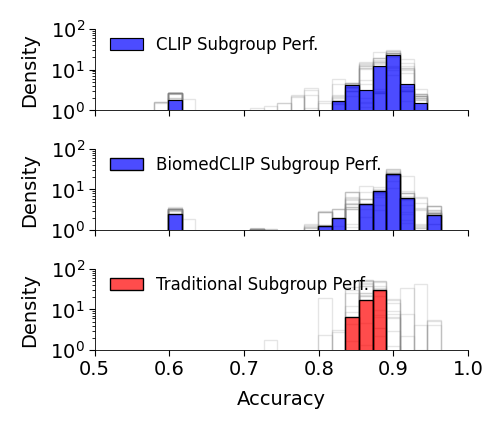

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def create_figure(n_rows, linewidth=3.0, axes_height=1.5, axes_width_fraction=0.8,
                  top_margin_inches=0.3, bottom_margin_inches=0.3, vertical_spacing_inches=0.2):
    """
    Creates a figure with n_rows subplots where each subplot (the drawing area)
    has the same fixed width and height.

    Parameters:
      - n_rows: Number of rows of subplots.
      - linewidth: Total figure width in inches.
      - axes_height: Desired height of each subplot's drawing area (in inches).
      - axes_width_fraction: Fraction of the total width that the drawing area should occupy.
      - top_margin_inches, bottom_margin_inches: Top and bottom margins (in inches).
      - vertical_spacing_inches: Vertical space between subplots (in inches).

    Returns:
      - fig: The created figure.
      - axes: A list (or array) of axes objects.
    """
    # Compute overall figure height so that each axes is axes_height tall.
    fig_height = top_margin_inches + bottom_margin_inches + n_rows * axes_height + (n_rows - 1) * vertical_spacing_inches

    # Create the figure with the total width and computed height.
    fig, axes = plt.subplots(n_rows, 1, figsize=(linewidth, fig_height), sharex=True)

    # Determine normalized margins so that the axes drawing area has fixed size.
    left = (1 - axes_width_fraction) / 2
    right = 1 - left
    bottom = bottom_margin_inches / fig_height
    top = 1 - top_margin_inches / fig_height
    # hspace is given relative to the axes height.
    hspace = vertical_spacing_inches / axes_height

    fig.subplots_adjust(left=left, right=right, bottom=bottom, top=top, hspace=hspace)
    return fig, axes
    
with plt.style.context("./plot_style.txt"):

    # Assume df is your DataFrame.
    # Define meta and discrimination column names.
    meta_subgroup_cols = [col for col in df.columns 
                        if col.startswith("meta_acc_") and col != "meta_avg_acc"]
    meta_overall = "meta_avg_acc"

    disc_subgroup_cols = [col for col in df.columns 
                        if col.startswith("disc_acc_") and col != "disc_avg_acc"]
    if "disc_avg_acc" in df.columns:
        disc_overall = "disc_avg_acc"
    elif "disc_acc_jitter" in df.columns:
        disc_overall = "disc_acc_jitter"
    else:
        raise ValueError("No discrimination overall accuracy column found.")

    # Optional: Define bins that span the range of both meta and disc accuracies.
    # This ensures both subplots share the same binning.
    # First, gather all meta and disc values.
    all_meta = pd.concat([df[col] for col in meta_subgroup_cols] + [df[meta_overall]])
    all_disc = pd.concat([df[col] for col in disc_subgroup_cols] + [df[disc_overall]])

    global_min = min(all_meta.min(), all_disc.min())
    global_max = max(all_meta.max(), all_disc.max())
    
    bins = np.linspace(global_min, global_max, 30)
    
    #edges = np.histogram_bin_edges(df[meta_overall], bins=bins)
    #binwidth = np.diff(edges)[0] * 5 # uniform bin width
    # Create the two-panel figure.
    #fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(3, 3))
    
    cm = 1/2.54  # centimeters in inches
    # Create subplots ONCE
    textwidth = 12.19826*cm
    #fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, ncols=1, sharex=True, sharey=True, figsize=(textwidth/2, textwidth/2))
    fig, (ax1, ax2, ax3) = create_figure(n_rows=3, linewidth=textwidth/2, axes_height=textwidth/14, axes_width_fraction=0.7)

    
    # Top subplot: ImageNetCLIP Subgroup Discovery
    for col in disc_perf_columns:
        sns.histplot(df[col], bins=bins, stat="density", element="bars", fill=False,
                    color="gray", alpha=0.2, ax=ax1)
    sns.histplot(df[disc_overall], bins=bins, stat="density", element="bars", fill=True,
                color="blue", alpha=0.7, label="CLIP Subgroup Perf.", ax=ax1)

    #ax1.set_title("Metadata-based Subgroups")
    ax1.set_ylabel("Density")
    ax1.set_ylim(1, 100)
    ax1.set_xlim(0.5, 1.0)
    ax1.set_yscale("log")

    ax1.legend(frameon=False, loc="upper left", bbox_to_anchor=(0, 1.1))

    # Mid subplot: CXR Subgroup Discovery
    for col in disc_perf_columns:
        sns.histplot(df_cxr[col], bins=bins, stat="density", element="bars", fill=False,
                    color="gray", alpha=0.2, ax=ax2)
    sns.histplot(df_cxr[disc_overall], bins=bins, stat="density", element="bars", fill=True,
                color="blue", alpha=0.7, label="BiomedCLIP Subgroup Perf.", ax=ax2)

    #ax1.set_title("Metadata-based Subgroups")
    ax2.set_ylabel("Density")
    ax2.set_ylim(1, 100)
    ax2.set_yscale("log")

    ax2.set_xlim(0.5, 1.0)
    ax2.legend(frameon=False, loc="upper left", bbox_to_anchor=(0, 1.1))    

    # Bottom subplot: Meta Accuracy Distribution using histograms
    for col in meta_subgroup_cols:
        sns.histplot(df[col], bins=bins, stat="density", element="bars", fill=False,
                    color="gray", alpha=0.2, ax=ax3)
    # Plot the overall meta accuracy in red (overlaid)
    sns.histplot(df[meta_overall], bins=bins, stat="density", element="bars", fill=True,
                color="red", alpha=0.7, label="Traditional Subgroup Perf.", ax=ax3)
    
    #ax2.set_title("Discovered Subgroups")
    ax3.set_xlabel("Accuracy")
    ax3.set_ylabel("Density")
    ax3.set_ylim(1, 100)
    ax3.set_yscale("log")

    ax3.set_xlim(0.5, 1.0)
    ax3.legend(frameon=False, loc="upper left", bbox_to_anchor=(0, 1.1))

    #plt.tight_layout()

    plt.savefig("l3_imagenet_10_log_half.pdf")#, bbox_inches="tight")

    plt.show()


# Joint Grid histogram

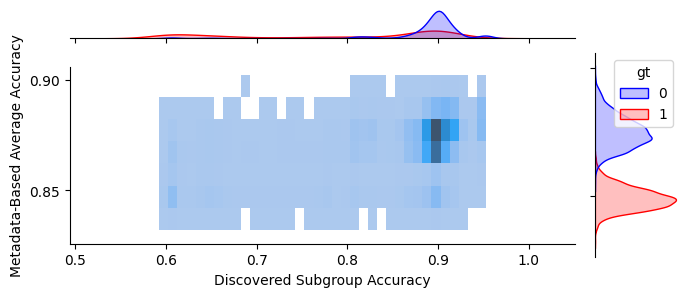

In [13]:
# --- Create a JointGrid for the plot ---

# Add jittering to avoid overlapping points
jitter_strength = 0.0  # Adjust this if needed
df["meta_avg_acc_jitter"] = df["meta_avg_acc"] + np.random.uniform(-jitter_strength, jitter_strength, size=len(df))
df["disc_avg_acc_jitter"] = df["disc_avg_acc"] + np.random.uniform(-jitter_strength, jitter_strength, size=len(df))


#with plt.style.context("../../subgroups_eval/plot_style.txt"):
# --- Create a JointGrid for the plot ---
g = sns.JointGrid(data=df, y="meta_avg_acc_jitter", x="disc_avg_acc_jitter", height=6)    # Adjust the aspect ratio (wider plot)

# Scatter plot with color for ground truth
#g.plot_joint(sns.scatterplot, data=df, hue="gt", palette={0: "blue", 1: "red"}, alpha=0.6, edgecolor="black")
g.plot_joint(sns.histplot, binwidth=(.01, .01))

# Marginal KDE plots for different gt values
sns.kdeplot(data=df, y="meta_avg_acc", hue="gt", palette={0: "blue", 1: "red"}, ax=g.ax_marg_y, common_norm=False, fill=True)
sns.kdeplot(data=df, x="disc_avg_acc", hue="gt", palette={0: "blue", 1: "red"}, ax=g.ax_marg_x, common_norm=False, fill=True)

g.figure.set_size_inches(7, 3)  # (width, height) → More horizontal
g.ax_joint.set_box_aspect(0.35) 

#g = sns.JointGrid(data=df, x="meta_avg_acc", y="disc_acc", height=8)
#g.plot_joint(sns.scatterplot, alpha=0.1)
#g.plot_marginals(sns.kdeplot)
# Set limits for both axes
#g.ax_joint.set_xlim(0.65, 0.92)
#g.ax_joint.set_ylim(0.65, 0.92)
#g.ax_marg_x.set_xlim(0.65, 0.92)
#g.ax_marg_y.set_ylim(0.65, 0.92)

# Draw identity line (y = x) for reference
#g.ax_joint.plot([0.65, 0.92], [0.65, 0.92], 'r--', label="y = x")
g.ax_joint.set_yticks([0.85, 0.90])  # Manually set fewer ticks
g.ax_marg_x.legend_.remove()  # Remove legend from marginal x-axis
#g.ax_marg_y.legend_.remove()  # Remove legend from marginal y-axis
#g.ax_joint.legend()  # Keep only the legend inside the main plot
# Axis labels and title
g.set_axis_labels( "Discovered Subgroup Accuracy", "Metadata-Based Average Accuracy")
#plt.suptitle("Comparison of Metadata vs. Discovered Subgroup Performance", y=1.02)

plt.tight_layout()
plt.show()
